# Pose2 SLAM Example

GTSAM Copyright 2010-2018, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved
Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

Simple Pose-SLAM example using only odometry measurements
Author: Alex Cunningham (C++), Kevin Deng & Frank Dellaert (Python)

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/python/gtsam/examples/Pose2SLAMExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates a simple 2D Simultaneous Localization and Mapping (SLAM) problem involving only robot poses and odometry measurements. A key aspect of this example is the inclusion of a **loop closure** constraint.

**Problem Setup:**
Imagine a robot moving in a 2D plane. It receives measurements of its own motion (odometry) between consecutive time steps. Odometry is notoriously prone to drift – small errors accumulate over time, causing the robot's estimated position to diverge from its true position.

**Loop Closure:**
A loop closure occurs when the robot recognizes a previously visited location. This provides a powerful constraint that links a later pose back to an earlier pose, significantly reducing accumulated drift. In this example, we simulate a loop closure by adding a factor that directly connects the last pose ($x_5$) back to an earlier pose ($x_2$).

**Factor Graph:**
We will build a factor graph representing:
1.  **Variables:** The unknown robot poses ($x_1, x_2, x_3, x_4, x_5$) at different time steps.
2.  **Factors:**
    *   A **Prior Factor** on the first pose ($x_1$), anchoring the map.
    *   **Odometry Factors** (Between Factors) connecting consecutive poses ($x_1 	o x_2$, $x_2 	o x_3$, etc.), representing the noisy relative motion measurements.
    *   A **Loop Closure Factor** (also a Between Factor) connecting the last pose ($x_5$) to an earlier pose ($x_2$), representing the constraint that the robot has returned to a known location.

We will then use GTSAM to optimize this factor graph and find the most likely sequence of robot poses given the measurements and the loop closure.

## 1. Setup and Imports

First, we install GTSAM if needed (e.g., in Google Colab) and import the necessary libraries: `gtsam`, `math` for PI, `matplotlib` for plotting, and `gtsam.utils.plot` for GTSAM-specific plotting functions.

In [ ]:
# Install GTSAM from pip if running in Google Colab
try:
    import google.colab
    %pip install --quiet gtsam-develop
except ImportError:
    pass # Not in Colab

In [15]:
import math
import graphviz
import numpy as np

import gtsam
import gtsam.utils.plot as gtsam_plot
import matplotlib.pyplot as plt

## 2. Define Noise Models

We define Gaussian noise models for our factors:

*   **Prior Noise:** Uncertainty on the initial pose ($x_1$). We assume the robot starts at the origin (0, 0, 0), but with some uncertainty.
*   **Odometry Noise:** Uncertainty on the relative motion measurements between poses. This applies to both the sequential odometry factors and the loop closure factor.

In [3]:
# Create noise models with specified standard deviations (sigmas).
# For Pose2, the noise is on (x, y, theta).
# Note: gtsam.Point3 is used here to represent the 3 sigmas (dx, dy, dtheta)

# Prior noise on the first pose (x, y, theta) - sigmas = [0.3m, 0.3m, 0.1rad]
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
# Odometry noise (dx, dy, dtheta) - sigmas = [0.2m, 0.2m, 0.1rad]
ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.2, 0.2, 0.1]))

## 3. Build the Factor Graph

Now, we create the factor graph. We'll use simple integer keys (1, 2, 3, 4, 5) to represent the poses $x_1$ through $x_5$.

In [4]:
# 1. Create a factor graph container
graph = gtsam.NonlinearFactorGraph()

### 3.1 Add Prior Factor

Add a `PriorFactorPose2` on the first pose (key `1`), setting it to the origin `gtsam.Pose2(0, 0, 0)` with the defined `PRIOR_NOISE`.

In [5]:
# 2a. Add a prior on the first pose (key 1)
graph.add(gtsam.PriorFactorPose2(1, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))

### 3.2 Add Odometry Factors

Add `BetweenFactorPose2` factors for the sequential movements:
*   $x_1 	o x_2$: Move 2m forward.
*   $x_2 	o x_3$: Move 2m forward, turn 90 degrees left ($\pi/2$).
*   $x_3 	o x_4$: Move 2m forward, turn 90 degrees left ($\pi/2$).
*   $x_4 	o x_5$: Move 2m forward, turn 90 degrees left ($\pi/2$).

Each factor uses the `ODOMETRY_NOISE` model.

In [6]:
# 2b. Add odometry factors (Between Factors)
# Between poses 1 and 2:
graph.add(gtsam.BetweenFactorPose2(1, 2, gtsam.Pose2(2, 0, 0), ODOMETRY_NOISE))
# Between poses 2 and 3:
graph.add(gtsam.BetweenFactorPose2(2, 3, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
# Between poses 3 and 4:
graph.add(gtsam.BetweenFactorPose2(3, 4, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))
# Between poses 4 and 5:
graph.add(gtsam.BetweenFactorPose2(4, 5, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))

### 3.3 Add Loop Closure Factor

This is the crucial step for correcting drift. We add a `BetweenFactorPose2` connecting the last pose ($x_5$, key `5`) back to the second pose ($x_2$, key `2`). The measurement represents the expected relative transform between pose 5 and pose 2 if the robot correctly returned to the location of $x_2$. We assume this measurement is also subject to `ODOMETRY_NOISE`.

The relative pose `gtsam.Pose2(2, 0, math.pi / 2)` implies that pose 2 is 2m ahead and rotated by +90 degrees relative to pose 5.

In [7]:
# 2c. Add the loop closure constraint
# This factor connects pose 5 back to pose 2
# The measurement is the expected relative pose from 5 to 2
graph.add(gtsam.BetweenFactorPose2(5, 2, gtsam.Pose2(2, 0, math.pi / 2), ODOMETRY_NOISE))

### 3.4 Inspect the Graph

Print the graph to see the factors and the variables they connect.

In [8]:
print("\nFactor Graph:\n{}".format(graph))


Factor Graph:
NonlinearFactorGraph: size: 6

Factor 0: PriorFactor on 1
  prior mean:  (0, 0, 0)
  noise model: diagonal sigmas [0.3; 0.3; 0.1];

Factor 1: BetweenFactor(1,2)
  measured:  (2, 0, 0)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 2: BetweenFactor(2,3)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 3: BetweenFactor(3,4)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 4: BetweenFactor(4,5)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];

Factor 5: BetweenFactor(5,2)
  measured:  (2, 0, 1.57079633)
  noise model: diagonal sigmas [0.2; 0.2; 0.1];




## 4. Create Initial Estimate

We need an initial guess for the optimizer. To illustrate the optimizer's power, we provide deliberately incorrect initial values for the poses in a `gtsam.Values` container. Without the loop closure, these errors would likely accumulate significantly.

In [9]:
# 3. Create the initial estimate for the solution
# These values are deliberately incorrect to show optimization.
initial_estimate = gtsam.Values()
initial_estimate.insert(1, gtsam.Pose2(0.5, 0.0, 0.2))
initial_estimate.insert(2, gtsam.Pose2(2.3, 0.1, -0.2))
initial_estimate.insert(3, gtsam.Pose2(4.1, 0.1, math.pi / 2))
initial_estimate.insert(4, gtsam.Pose2(4.0, 2.0, math.pi))
initial_estimate.insert(5, gtsam.Pose2(2.1, 2.1, -math.pi / 2))

print("\nInitial Estimate:\n{}".format(initial_estimate))


Initial Estimate:
Values with 5 values:
Value 1: (gtsam::Pose2)
(0.5, 0, 0.2)

Value 2: (gtsam::Pose2)
(2.3, 0.1, -0.2)

Value 3: (gtsam::Pose2)
(4.1, 0.1, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2.1, 2.1, -1.57079633)




Now that we have an initial estimate we can also visualize the graph:

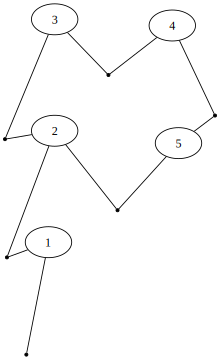

In [17]:
display(graphviz.Source(graph.dot(initial_estimate), engine='neato'))

## 5. Optimize the Factor Graph

We'll use the Gauss-Newton optimizer to find the most likely configuration of poses.

1.  Set optimization parameters using `gtsam.GaussNewtonParams` (e.g., error tolerance, max iterations).
2.  Create the `gtsam.GaussNewtonOptimizer` instance with the graph, initial estimate, and parameters.
3.  Run `optimizer.optimize()`.

In [10]:
# 4. Optimize the initial values using Gauss-Newton
parameters = gtsam.GaussNewtonParams()

# Set optimization parameters
parameters.setRelativeErrorTol(1e-5) # Stop when change in error is small
parameters.setMaxIterations(100)     # Limit iterations

# Create the optimizer
optimizer = gtsam.GaussNewtonOptimizer(graph, initial_estimate, parameters)

# Optimize!
result = optimizer.optimize()

print("\nFinal Result:\n{}".format(result))


Final Result:
Values with 5 values:
Value 1: (gtsam::Pose2)
(-8.50051783e-21, -7.35289215e-20, -2.34289062e-20)

Value 2: (gtsam::Pose2)
(2, -1.53066255e-19, -3.05180521e-20)

Value 3: (gtsam::Pose2)
(4, -3.42173677e-11, 1.57079633)

Value 4: (gtsam::Pose2)
(4, 2, 3.14159265)

Value 5: (gtsam::Pose2)
(2, 2, -1.57079633)




## 6. Calculate Marginal Covariances

After optimization, we can compute the uncertainty (covariance) associated with each estimated pose using `gtsam.Marginals`.

In [11]:
# 5. Calculate and print marginal covariances
marginals = gtsam.Marginals(graph, result)
print("\nMarginal Covariances:")
for i in range(1, 6):
    print(f"X{i} covariance:\n{marginals.marginalCovariance(i)}\n")


Marginal Covariances:
X1 covariance:
[[ 9.00000000e-02  1.96306337e-18 -1.49103687e-17]
 [ 1.96306337e-18  9.00000000e-02 -7.03437308e-17]
 [-1.49103687e-17 -7.03437308e-17  1.00000000e-02]]

X2 covariance:
[[ 1.30000000e-01 -3.89782542e-17 -4.37043325e-17]
 [-3.89782542e-17  1.70000000e-01  2.00000000e-02]
 [-4.37043325e-17  2.00000000e-02  2.00000000e-02]]

X3 covariance:
[[ 3.62000000e-01 -3.29291732e-12  6.20000000e-02]
 [-3.29291394e-12  1.62000000e-01 -2.00000000e-03]
 [ 6.20000000e-02 -2.00000000e-03  2.65000000e-02]]

X4 covariance:
[[ 0.268 -0.128  0.048]
 [-0.128  0.378 -0.068]
 [ 0.048 -0.068  0.028]]

X5 covariance:
[[ 0.202   0.036  -0.018 ]
 [ 0.036   0.26   -0.051 ]
 [-0.018  -0.051   0.0265]]



## 7. Visualize Results

Finally, we use `gtsam.utils.plot.plot_pose2` to visualize the optimized poses along with their covariance ellipses. Notice how the poses form a square, and the loop closure (connecting pose 5 back to pose 2) helps maintain this structure despite the initial errors and odometry noise. The covariance ellipses show the uncertainty, which is typically smallest at the prior (pose 1) and might be reduced near the loop closure.

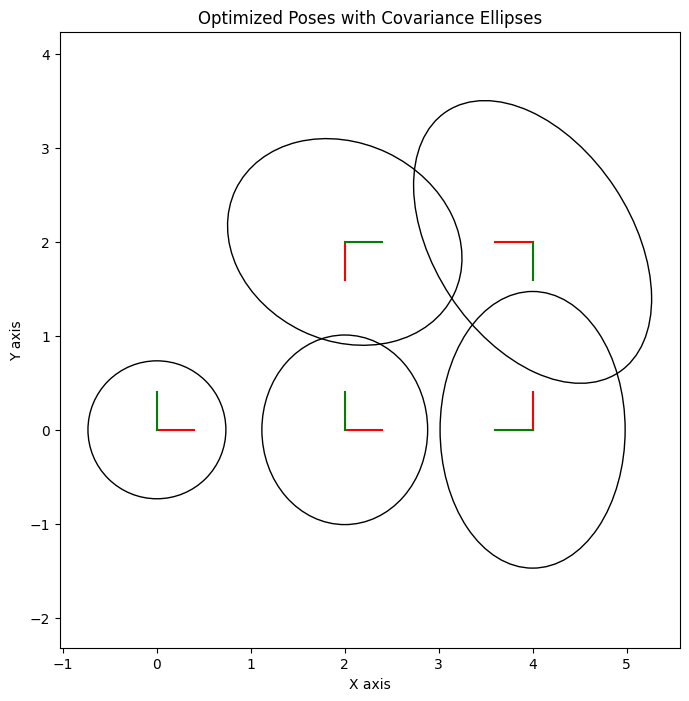

In [13]:
# Plot the results
fig = plt.figure(0, figsize=(8, 8))

for i in range(1, 6):
    # Plot pose with covariance ellipse
    gtsam_plot.plot_pose2(fig.number, result.atPose2(i), axis_length=0.4,
                           covariance=marginals.marginalCovariance(i))

# Adjust plot settings
plt.title("Optimized Poses with Covariance Ellipses")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.axis('equal') # Ensure equal scaling on x and y axes
plt.show()      # Display the plot

## Summary

This example demonstrated a Pose SLAM problem where:
1.  We modeled robot poses and odometry measurements using a `gtsam.NonlinearFactorGraph`.
2.  A prior was added to the first pose.
3.  Sequential odometry factors were added between consecutive poses.
4.  A crucial loop closure factor was added, connecting the last pose back to an earlier one.
5.  An inaccurate initial estimate was provided.
6.  The `gtsam.GaussNewtonOptimizer` was used to find the optimal pose estimates.
7.  Marginal covariances were calculated to show the uncertainty.
8.  The results, including covariance ellipses, were visualized, highlighting the effect of the loop closure in correcting drift.